# Empirical Asset Pricing - PS6

Maximilian Huber

## Task 1

In [1]:
using CSV, DataFrames, Plots; gr();

In [2]:
options = CSV.read("./Data/37d329c9b7427334.csv", dateformat = "yyyymmdd", allowmissing=:none, 
    use_mmap = false, 
    types = [Date, Date, Char, Int32, Float32, Float32, Int32, Int8, String, Char])

delete!(options, :issuer)
delete!(options, :exercise_style)
delete!(options, :index_flag)

options[:cp_flag] = options[:cp_flag] .== 'C'
rename!(options, :cp_flag => :call)

options[:strike_price] = options[:strike_price] ./ 1000

sort!(options, cols = :date)

head(options)

,date,exdate,call,strike_price,best_bid,best_offer,optionid
1,1996-01-04,1997-06-21,false,500.0,6.0,6.875,10497848
2,1996-01-04,1996-03-16,true,600.0,24.75,25.75,10003226
3,1996-01-04,1996-02-17,false,605.0,4.875,5.375,10465737
4,1996-01-04,1996-12-21,true,600.0,55.75,56.25,10500861
5,1996-01-04,1996-03-16,false,540.0,0.75,1.0,10501049
6,1996-01-04,1996-02-17,false,630.0,15.75,16.5,10430693


In [3]:
spx = CSV.read("./Data/7ec2694205f0f4e1.csv", dateformat = "yyyymmdd", allowmissing=:none, 
    use_mmap = false, types = [Date, Float32])
rename!(spx, :DATE => :date)
trading_dates = unique(options[:date])
spx = vcat([spx[searchsortedfirst(spx[:date], d), :] for d in trading_dates]...)
head(spx)

,date,spindx
1,1996-01-04,617.7
2,1996-01-05,616.72
3,1996-01-08,618.46
4,1996-01-09,609.45
5,1996-01-10,598.48
6,1996-01-11,602.69


### Preliminaries
I observed that the price of options on the day that they expire is odd. If one bought or sold options on the day of their expiry one could frequently make profits:

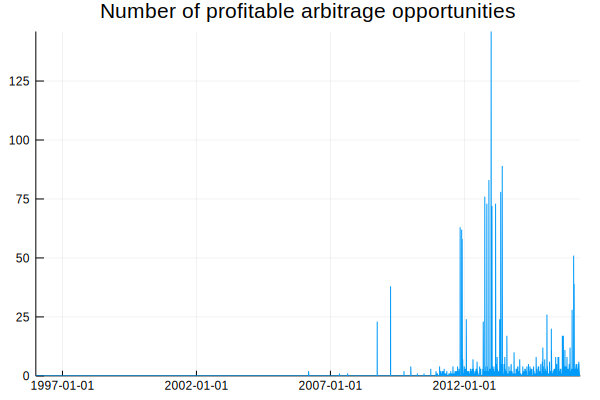

In [4]:
expired = options[options[:date] .== options[:exdate], :] #on the day of expiry
incorrect = expired[
    ((max.((-1.0) .^ (.!expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) - expired[:best_offer]) .> 0) .|  #buy an option and exercise it if it is good
    ((min.((-1.0) .^ (expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) + expired[:best_bid]) .> 0) , :] #sell an option and fulfill if it is exercised

plot(trading_dates, [length(searchsorted(incorrect[:date], d)) for d in trading_dates], title = "Number of profitable arbitrage opportunities", label = "")

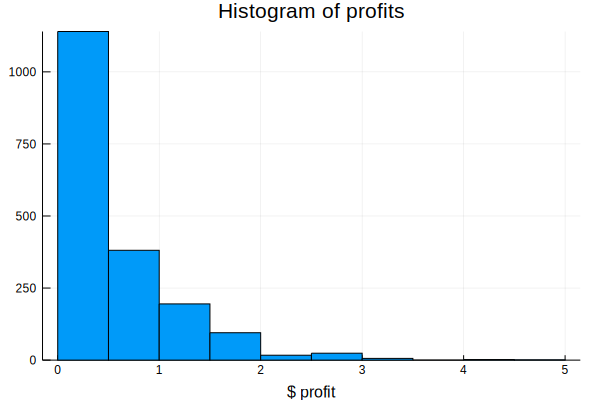

In [5]:
histogram(vcat((max.((-1.0) .^ (.!expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) - expired[:best_offer])[(max.((-1.0) .^ (.!expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) - expired[:best_offer]) .> 0],  #buy an option and exercise it if it is good
    (min.((-1.0) .^ (expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) + expired[:best_bid])[(min.((-1.0) .^ (expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) + expired[:best_bid]) .> 0]), bins = 0:0.5:5, title = "Histogram of profits", label = "", xlab = "\$ profit")

I conclude that I will never want to use the price of an option on the day of its expiry. Hence, in (b) I choose a minimal duration to be a few days longer than a month.

### (b) Writing Straddles
On every day for which there is options data available I sell one ATM call and and one ATM put and receive the `best_bid` price. I then look up the `best_offer` price of the respective options via `optionid` on the first day after 29 days from selling the options.

I use two different schemes to select the options that are sold, and then bought back in a month:
* a scheme that focuses on achieving at-the-money
* a scheme that focuses on achieving time-to-maturity

In [27]:
function ATM_focused_scheme(options, trading_dates; last_day = Date(2016, 3, 31), min_days = 33)
    
    N = findlast(trading_dates .<= last_day)
    
    ret = zeros(N)
    dist = zeros(N)
    idcall = zeros(Int32, N)
    idput = zeros(Int32, N)
    sdate = Array{Date, 1}(N)
    ttm = zeros(Dates.Day, N)

    for (i, d) in enumerate(trading_dates[1:N])
        
        ignore = 0 #in case there is no put/call pair with the strike closest to the index price, I start ignoring those options.
        selected = searchsorted(options[:date], d) #correct date        
        
        while true #break if search was successfull
            
            selected = searchsorted(options[:date], d)
            dist_price = abs.(options[selected, :strike_price] .- spx[i, :spindx])
            selected = selected[dist_price .≈ minimum(sort(dist_price)[(ignore+1):end])] #closested to ATM, possibly ignoring the closest
            selected = selected[options[selected, :strike_price] .== minimum(options[selected, :strike_price])] #if two strike levels are equally close to ATM
            selected = selected[(options[selected, :exdate] .- d) .>= Dates.Day(min_days)] #at least 33 days until maturity

            if length(selected) < 2 #no two closest contracts that have a high enough duration
                ignore += 1
                continue
            end

            earliest_selected = selected[options[selected, :exdate] .== minimum(options[selected, :exdate])] #earliest exp

            if length(earliest_selected) == 1 #only one contract! increase the maturity
                earliest_selected = selected[options[selected, :exdate] .== minimum(sort(options[selected, :exdate])[2:end])] #earliest exp
            end
                      
            selected = earliest_selected
            
            sell_date = trading_dates[findfirst((trading_dates .- d) .>= Dates.Day(min_days-4))]
            sell_options = options[searchsorted(options[:date], sell_date), :]
            
            try
                ret[i] = Float64(sum(options[selected, :best_bid]) / 
                    (sell_options[sell_options[:optionid] .== options[selected[1], :optionid], :best_offer][1] + 
                    sell_options[sell_options[:optionid] .== options[selected[2], :optionid], :best_offer][1]) - 1)
            catch
                ignore += 1
                warn("No sell data at $i $d $sell_date for $(options[selected[1], :optionid]) $(options[selected[2], :optionid])")
            finally
                sdate[i] = sell_date
                idcall[i] = options[selected, :][options[selected, :call], :optionid][1]
                idput[i] = options[selected, :][.!options[selected, :call], :optionid][1]
                dist[i] = (options[selected, :strike_price][1] - spx[i, :spindx]) / spx[i, :spindx] * 100
                ttm[i] = options[selected, :exdate][1] - d

                break
            end
        end
    end
    
    return DataFrame([trading_dates[1:N], ret, idcall, idput, sdate, dist, ttm], [:date, :return, :idcall, :idput, :sdate, :dist, :ttm])
end

ATM_focused_scheme (generic function with 1 method)

In [28]:
function TTM_focused_scheme(options, trading_dates; last_day = Date(2016, 3, 31), min_days = 33)
    
    N = findlast(trading_dates .<= last_day)
    
    ret = zeros(N)
    dist = zeros(N)
    idcall = zeros(Int32, N)
    idput = zeros(Int32, N)
    sdate = Array{Date, 1}(N)
    ttm = zeros(Dates.Day, N)

    
    for (i, d) in enumerate(trading_dates[1:N])
               
        extra_days = 0 #in case there is no put/call pair with the strike closest to the index price, I start ignoring those options.
        selected = searchsorted(options[:date], d) #correct date        

        while true
            selected = searchsorted(options[:date], d) #correct date

            selected = selected[(options[selected, :exdate] .- d) .>= Dates.Day(min_days + extra_days)] #at least some days until maturity
            selected = selected[options[selected, :exdate] .== minimum(options[selected, :exdate])] #earliest exp

            dist_price = abs.(options[selected, :strike_price] .- spx[i, :spindx])
            strike_selected = selected[dist_price .≈ minimum(dist_price)] #closested to ATM
            strike_selected = strike_selected[options[strike_selected, :strike_price] .== minimum(options[strike_selected, :strike_price])] #if two strike levels are equally close to ATM

            if length(strike_selected) == 1 #only one contract available! choose different strike!
                strike_selected = selected[dist_price .≈ minimum(sort(dist_price)[2:end])]
                strike_selected = strike_selected[options[strike_selected, :strike_price] .== minimum(options[strike_selected, :strike_price])] #if two strike levels are equally close to ATM
            end

            if length(strike_selected) != 2
                warn("Had to increase time-to-maturity because not enough contracts at $d")
                extra_days += 21
                continue
            else
                selected = strike_selected
                break
            end
        end
       
        #write info about sold options
        idcall[i] = options[selected, :][options[selected, :call], :optionid][1]
        idput[i] = options[selected, :][.!options[selected, :call], :optionid][1]
        dist[i] = (options[selected, :strike_price][1] - spx[i, :spindx]) / spx[i, :spindx] * 100
        ttm[i] = options[selected, :exdate][1] - d 
             
        #select only relevent options, increases performance!
        sell_options = searchsortedfirst(options[:date], d + Dates.Day(min_days - 4)):searchsortedlast(options[:date], d + Dates.Day(min_days + 14))
        
        #find buy-back date: earliest date where both have a price!
        sell_date = minimum(intersect(options[sell_options, :][(options[sell_options, :optionid] .== idcall[i]) .& (options[sell_options, :date] .>= d + Dates.Day(min_days - 4)), :date],
            options[sell_options, :][(options[sell_options, :optionid] .== idput[i]) .& (options[sell_options, :date] .>= d + Dates.Day(min_days - 4)), :date]))

        sell_options = options[searchsorted(options[:date], sell_date), :]
     
        ret[i] = Float64(sum(options[selected, :best_bid]) / 
            (sell_options[sell_options[:optionid] .== options[selected[1], :optionid], :best_offer][1] + 
            sell_options[sell_options[:optionid] .== options[selected[2], :optionid], :best_offer][1]) - 1)
        
        sdate[i] = sell_date
    end
    
    return DataFrame([trading_dates[1:N], ret, idcall, idput, sdate, dist, ttm], [:date, :return, :idcall, :idput, :sdate, :dist, :ttm])
end

TTM_focused_scheme (generic function with 1 method)

#### Evaluation of the Strategy
I evaluate both schemes:

In [53]:
returns_atm = ATM_focused_scheme(options, trading_dates);
returns_ttm = TTM_focused_scheme(options, trading_dates);

There are not many errors keeping in mind that I evaluate the strategy for every day. 

The ATM-focused scheme is more concentrated around the zero percent deviation from ATM, while the TTM-focused scheme has shorter time-to-maturity. The holding periods are equal. And the two scheme regularly select different options:

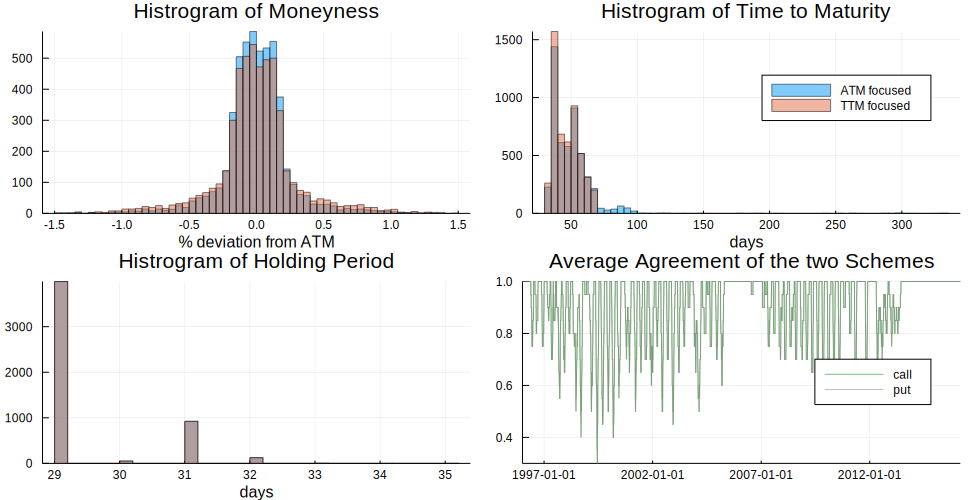

In [30]:
# plots to assess how well the strategy is fulfilled
p1 = histogram(returns_atm[:dist], xlab = "% deviation from ATM", label = "", title = "Histrogram of Moneyness", alpha = 0.5)
histogram!(p1, returns_ttm[:dist], label = "", alpha = 0.5)
p2 = histogram(Dates.value.(returns_atm[:ttm]), xlab = "days", label = "ATM focused", title = "Histrogram of Time to Maturity", alpha = 0.5, legend = :topright)
histogram!(p2, Dates.value.(returns_ttm[:ttm]), label = "TTM focused", nbins=20, alpha = 0.5)
p3 = histogram(Dates.value.(returns_atm[:sdate] .- returns_atm[:date]), xlab = "days", label = "", title = "Histrogram of Holding Period", alpha = 0.5)
histogram!(p3, Dates.value.(returns_ttm[:sdate] .- returns_ttm[:date]), xlab = "days", label = "", title = "Histrogram of Holding Period", alpha = 0.5)

p4 = plot(returns_atm[1:end-19, :date], [mean(((returns_atm[:idcall] .- returns_ttm[:idcall]) .== 0)[i:i+19]) for i in 1:size(returns_atm, 1)-19], color = :green, label = "call", alpha = 0.5, title = "Average Agreement of the two Schemes", legend = :bottomright)
plot!(p4, returns_atm[1:end-19, :date], [mean(((returns_atm[:idput] .- returns_ttm[:idput]) .== 0)[i:i+19]) for i in 1:size(returns_atm, 1)-19], color = :grey, label = "put", alpha = 0.5)

plot(p1, p2, p3, p4, size=(980, 500))

If I execute the trading strategy on the end of every month the return is. The two schemes perform very similarly:

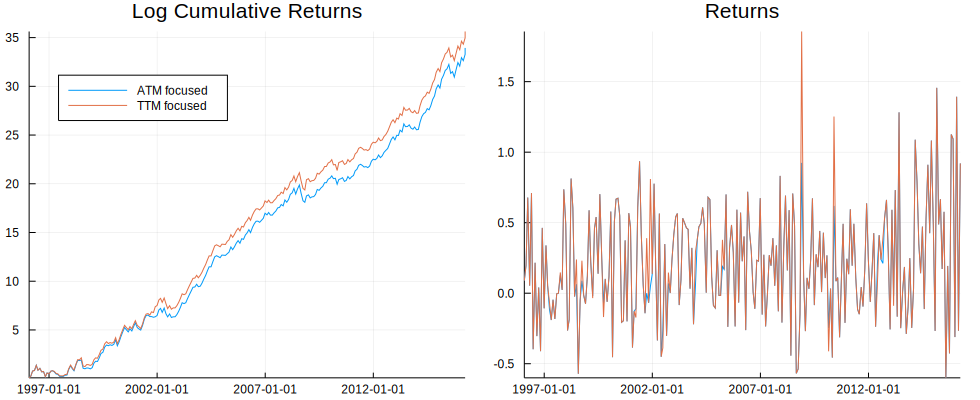

In [31]:
# plot the performance
trading_dates_last = unique(Dates.lastdayofmonth.(trading_dates)) #desired months
trading_dates_last = [maximum(returns_atm[returns_atm[:date] .<= month, :date]) for month in trading_dates_last]

p1 = plot(trading_dates_last, (cumsum(log.([returns_atm[returns_atm[:date] .== d, :return][1] for d in trading_dates_last] + 1))), label = "ATM focused", legend = :topleft, title = "Log Cumulative Returns")
plot!(p1, trading_dates_last, (cumsum(log.([returns_ttm[returns_ttm[:date] .== d, :return][1] for d in trading_dates_last] + 1))), label = "TTM focused")

p2 = plot(trading_dates_last, [returns_atm[returns_atm[:date] .== d, :return][1] for d in trading_dates_last], label = "", legend = :bottomright, title = "Returns")
plot!(p2, trading_dates_last, [returns_ttm[returns_ttm[:date] .== d, :return][1] for d in trading_dates_last], label = "")

plot(p1, p2, size=(980, 400))

### (c)

In [54]:
returns_atm1y = ATM_focused_scheme(options, trading_dates, last_day = Date(2015, 3, 31), min_days = 368)
returns_ttm1y = TTM_focused_scheme(options, trading_dates, last_day = Date(2015, 3, 31), min_days = 368);

There are some more instances where there is no price at the desired buy-back date and quite a few times there are not enough contracts traded on a sell day.

Again, the ATM-focused scheme yields lower deviation from ATM, while the TTM-focused scheme has no time-to-maturity outliers but has moneyness outliers. The strategies agree quite often, but with episodes of significant deviation:

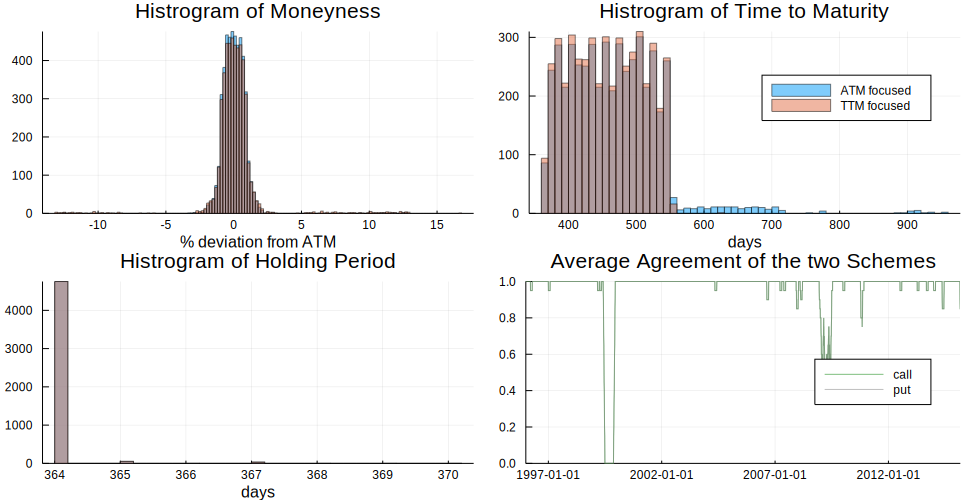

In [56]:
# plots to assess how well the strategy is fulfilled
p1 = histogram(returns_atm1y[:dist], xlab = "% deviation from ATM", label = "", title = "Histrogram of Moneyness", alpha = 0.5)
histogram!(p1, returns_ttm1y[:dist], label = "", alpha = 0.5)
p2 = histogram(Dates.value.(returns_atm1y[:ttm]), xlab = "days", label = "ATM focused", title = "Histrogram of Time to Maturity", alpha = 0.5, legend = :topright)
histogram!(p2, Dates.value.(returns_ttm1y[:ttm]), label = "TTM focused", nbins=40, alpha = 0.5)
p3 = histogram(Dates.value.(returns_atm1y[:sdate] .- returns_atm1y[:date]), xlab = "days", label = "", title = "Histrogram of Holding Period", alpha = 0.5)
histogram!(p3, Dates.value.(returns_ttm1y[:sdate] .- returns_ttm1y[:date]), xlab = "days", label = "", title = "Histrogram of Holding Period", alpha = 0.5)

p4 = plot(returns_atm1y[1:end-19, :date], [mean(((returns_atm1y[:idcall] .- returns_ttm1y[:idcall]) .== 0)[i:i+19]) for i in 1:size(returns_atm1y, 1)-19], color = :green, label = "call", alpha = 0.5, title = "Average Agreement of the two Schemes", legend = :bottomright)
plot!(p4, returns_atm1y[1:end-19, :date], [mean(((returns_atm1y[:idput] .- returns_ttm1y[:idput]) .== 0)[i:i+19]) for i in 1:size(returns_atm1y, 1)-19], color = :grey, label = "put", alpha = 0.5)

plot(p1, p2, p3, p4, size=(980, 500))

If I chose to execute the strategy on the last trading date of every year, the performance would be:

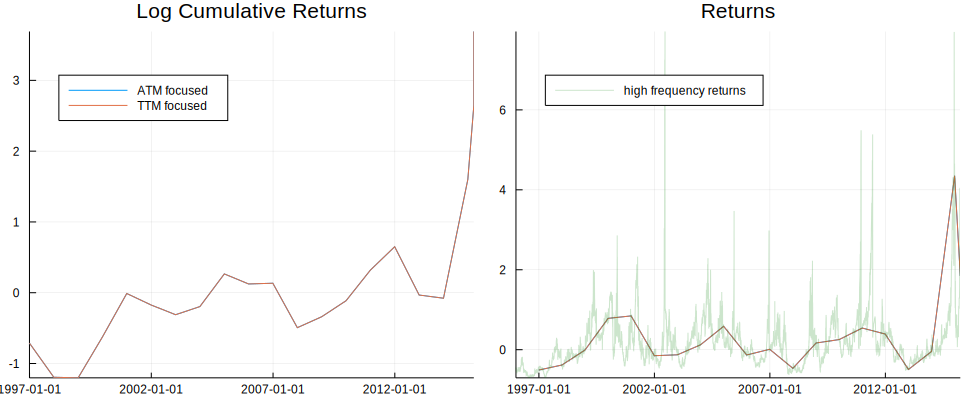

In [58]:
# plot the performance
trading_dates_last = unique(Dates.lastdayofyear.(trading_dates)) #desired dates
trading_dates_last = [maximum(returns_atm1y[returns_atm1y[:date] .<= month, :date]) for month in trading_dates_last]

p1 = plot(trading_dates_last, (cumsum(log.([returns_atm1y[returns_atm1y[:date] .== d, :return][1] for d in trading_dates_last] + 1))), label = "ATM focused", legend = :topleft, title = "Log Cumulative Returns")
plot!(p1, trading_dates_last, (cumsum(log.([returns_ttm1y[returns_ttm1y[:date] .== d, :return][1] for d in trading_dates_last] + 1))), label = "TTM focused")

p2 = plot(trading_dates_last, [returns_atm1y[returns_atm1y[:date] .== d, :return][1] for d in trading_dates_last], label = "", legend = :bottomright, title = "Returns")
plot!(p2, trading_dates_last, [returns_ttm1y[returns_ttm1y[:date] .== d, :return][1] for d in trading_dates_last], label = "")
plot!(p2, trading_dates[1:4843], [returns_atm1y[returns_atm1y[:date] .== d, :return][1] for d in trading_dates[1:4843]], label = "high frequency returns", legend = :topleft, title = "Returns", alpha = 0.2, color = :green)

plot(p1, p2, size=(980, 400))

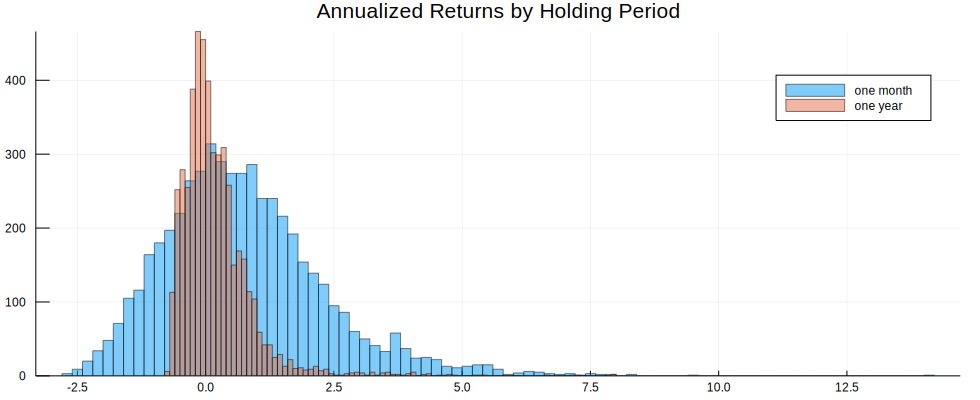

In [64]:
histogram(sqrt(12) .* returns_atm[:return], label = "one month", title = "Annualized Returns by Holding Period", alpha = 0.5)
histogram!(returns_atm1y[:return], label = "one year", alpha = 0.5, size=(980, 400))